In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
df = pd.read_csv("/content/drive/MyDrive/INDONESIA AI/DWIMAS ARIE/SALES FORECASTING/store5.csv")

In [4]:
# Mengatur kolom 'date' sebagai indeks
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")

#Drop fitur
df.drop(columns=["id", "store_nbr", "dcoilwtico"], inplace=True)


# Mengatur kolom 'date' sebagai indeks

df_poultry = df[df["family"] == "POULTRY"]
df_poultry.set_index("date", inplace=True)
df_poultry = df_poultry['sales'].resample("W-MON").sum()
df_poultry = np.log(df_poultry)
df_poultry.index = pd.date_range(start=df_poultry.index.min(), end=df_poultry.index.max(), freq='W-MON')
df_poultry = df_poultry.to_frame()

In [5]:
# Cek Stasioner dengan ADFULLER
result = adfuller(df_poultry['sales'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
# If p-value > 0.05, data is non-stationary and we need to difference

ADF Statistic: -1.2992173832301148
p-value: 0.6295302857005829


In [6]:
# Cek Stasioner dengan ADFULLER , diff - 1
result = adfuller(df_poultry['sales'].diff().dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')


ADF Statistic: -8.651134026073715
p-value: 5.1117775340245185e-14


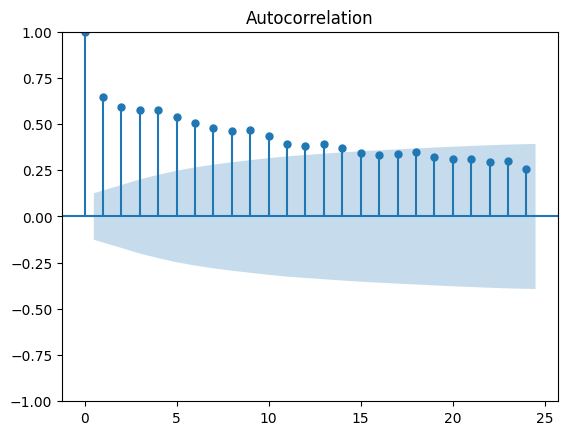

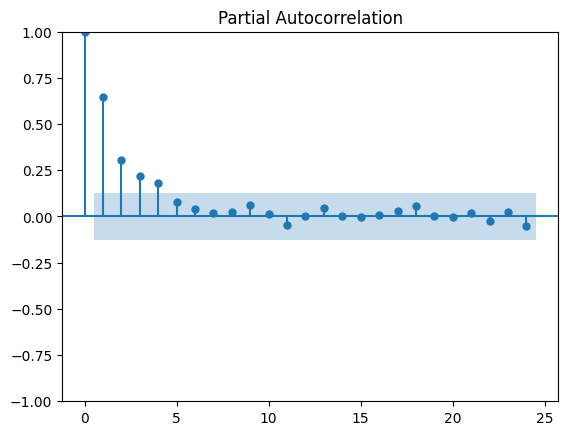

In [7]:
# Plot ACF,PACF original data
plot_acf(df_poultry['sales'].dropna())
plot_pacf(df_poultry['sales'].dropna())
plt.show()

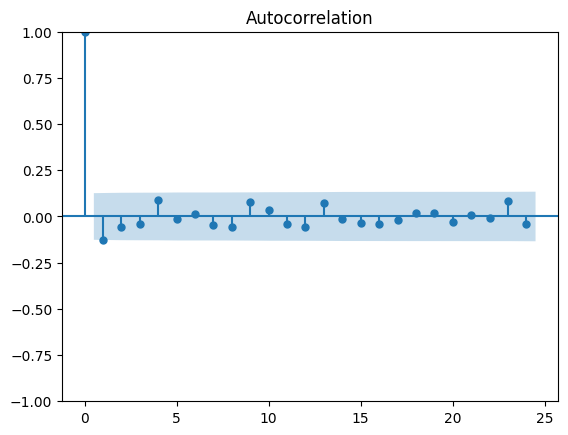

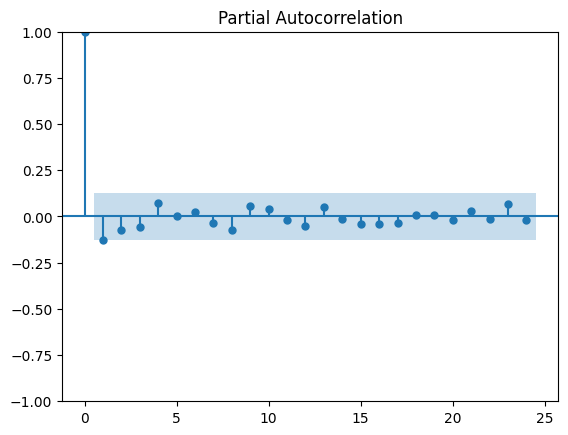

In [8]:
# Plot ACF,PACF diff 1
plot_acf(df_poultry['sales'].diff().dropna())
plot_pacf(df_poultry['sales'].diff().dropna())
plt.show()

In [9]:
# walaupun sudah diketahui pdq, kita lanjutkan dengan grid search (0,1,1)
import itertools

p = d = q = range(0, 2)
P = D = Q = range(0, 2)
s = 12  # mengansumsikan seasonal dengan data bulanan


In [10]:
# mencoba semua kombinasi of p, d, q, P, D, Q
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], s) for x in list(itertools.product(P, D, Q))]

best_aic = np.inf
best_params = None

for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            mod = SARIMAX(df_poultry['sales'],
                          order=param,
                          seasonal_order=seasonal_param,
                          enforce_stationarity=False,
                          enforce_invertibility=False)
            results = mod.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_params = (param, seasonal_param)
        except:
            continue

print(f'Best SARIMA parameters: {best_params} with AIC: {best_aic}')

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Best SARIMA parameters: ((0, 1, 1), (0, 0, 0, 12)) with AIC: -192.13622340665987


In [11]:
from sklearn.metrics import mean_squared_error as mse, mean_absolute_percentage_error as mape

# Train mode denga parameter terbaik
best_model = SARIMAX(df_poultry['sales'],
                     order=best_params[0],
                     seasonal_order=best_params[1],
                     enforce_stationarity=False,
                     enforce_invertibility=False)
best_model_fit = best_model.fit()

# Forecast
train_size = int(len(df_poultry) * 0.8)
train_data, test_data = df_poultry.iloc[:train_size], df_poultry.iloc[train_size:]

train_pred = best_model_fit.predict(start=train_data.index.min(), end=train_data.index.max(), typ="levels")
test_pred = best_model_fit.predict(start=test_data.index.min(), end=test_data.index.max(), typ="levels")

train_pred_exp = np.exp(train_pred)
test_pred_exp = np.exp(test_pred)
train_data_exp = np.exp(train_data['sales'])
test_data_exp = np.exp(test_data['sales'])

train_rmse = mse(train_data_exp, train_pred_exp, squared=False)
test_rmse = mse(test_data_exp, test_pred_exp, squared=False)

train_mape = mape(train_data_exp, train_pred_exp) * 100
test_mape = mape(test_data_exp, test_pred_exp) * 100

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Train MAPE: {train_mape}")
print(f"Test MAPE: {test_mape}")

Train RMSE: 228.60175612638494
Test RMSE: 247.5839616359236
Train MAPE: 7.691231125747208
Test MAPE: 18.52959291378231


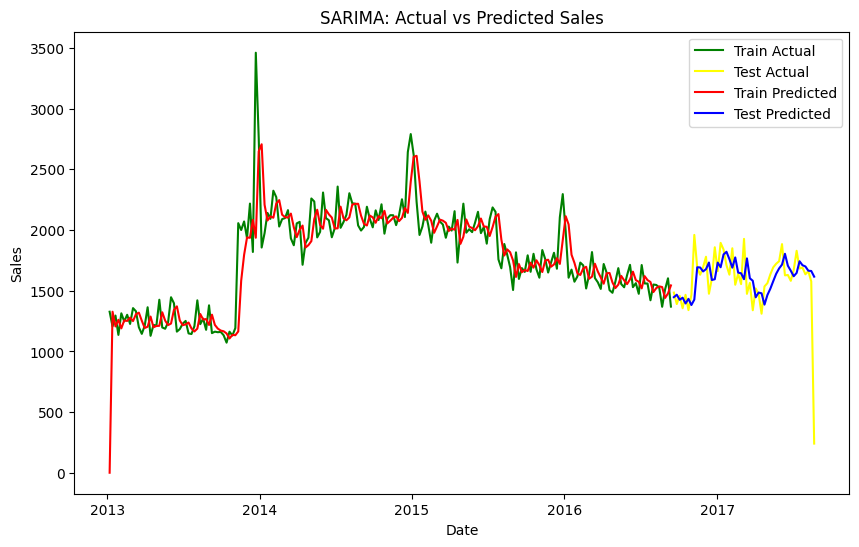

In [12]:
# plot prediksi
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data_exp, color='green', label='Train Actual')
plt.plot(test_data.index, test_data_exp, color='yellow', label='Test Actual')
plt.plot(train_data.index, train_pred_exp, color='red', label='Train Predicted')
plt.plot(test_data.index, test_pred_exp, color='blue', label='Test Predicted')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('SARIMA: Actual vs Predicted Sales')
plt.legend()
plt.show()